# Quantum - Error Mitigation

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
import numpy as np
import scipy.linalg as la
from qiskit.visualization import plot_histogram

In [2]:
def get_noise(p):
    error_meas = pauli_error([('X',p), ('I', 1 - p)])
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements 
    return noise_model

In [3]:
noise_model = get_noise(0.01)

for state in ['00','01','10','11']:
    qc = QuantumCircuit(2,2)
    if state[0] == '1':
        qc.x(1)
    if state[1] == '1':
        qc.x(0)
    qc.measure(qc.qregs[0], qc.cregs[0])
    print(state+' becomes',execute(qc, Aer.get_backend('qasm_simulator'),noise_model=noise_model,shots=10000).result().get_counts())

00 becomes {'01': 105, '00': 9793, '10': 102}
01 becomes {'00': 83, '01': 9822, '11': 95}
10 becomes {'01': 1, '00': 91, '10': 9824, '11': 84}
11 becomes {'01': 109, '11': 9810, '00': 2, '10': 79}


In [4]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)
qc.measure(qc.qregs[0], qc.cregs[0])
print(execute(qc, Aer.get_backend('qasm_simulator'),noise_model=noise_model,shots=10000).result().get_counts())

{'01': 87, '10': 92, '00': 4903, '11': 4918}


In [5]:
M = [[ 0.9777, 0.0112, 0.0100, 0.0002 ], 
     [ 0.0112, 0.9778, 0.0001, 0.0109 ],
     [ 0.0100, 0.0000, 0.9788, 0.0112 ],
     [ 0.0002, 0.0084, 0.0113, 0.9801 ]]

Cideal = [[5000],
          [0],
          [0],
          [5000]]

Cnoisy = np.dot(M, Cideal)
print('C_noisy =\n',Cnoisy)

C_noisy =
 [[4889.5]
 [ 110.5]
 [ 106. ]
 [4901.5]]


In [6]:
Minv = la.inv(M)
print(Minv)

[[ 1.02304976e+00 -1.17186559e-02 -1.04513578e-02  4.09943919e-05]
 [-1.17173704e-02  1.02293597e+00  1.46531715e-04 -1.13756757e-02]
 [-1.04522210e-02  2.20044977e-04  1.02190076e+00 -1.16779885e-02]
 [ 1.21682031e-05 -8.76727366e-03 -1.17810623e-02  1.02053618e+00]]


In [7]:
Cmeasured = [4900, 104, 98, 4898]
Cmitigated = np.dot(Minv, Cmeasured)
print('Cmitigated = \n',Cmitigated)

Cmitigated = 
 [5010.90166117   -6.73347357   -8.24551171 4996.57948692]


In [8]:
qr = QuantumRegister(2)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

for circuit in meas_calibs:
    print('Circuit',circuit.name)
    print(circuit)
    print()

Circuit mcalcal_00
        ░ ┌─┐   
q40_0: ─░─┤M├───
        ░ └╥┘┌─┐
q40_1: ─░──╫─┤M├
        ░  ║ └╥┘
 c0: 2/════╩══╩═
           0  1 

Circuit mcalcal_01
       ┌───┐ ░ ┌─┐   
q40_0: ┤ X ├─░─┤M├───
       └───┘ ░ └╥┘┌─┐
q40_1: ──────░──╫─┤M├
             ░  ║ └╥┘
 c0: 2/═════════╩══╩═
                0  1 

Circuit mcalcal_10
             ░ ┌─┐   
q40_0: ──────░─┤M├───
       ┌───┐ ░ └╥┘┌─┐
q40_1: ┤ X ├─░──╫─┤M├
       └───┘ ░  ║ └╥┘
 c0: 2/═════════╩══╩═
                0  1 

Circuit mcalcal_11
       ┌───┐ ░ ┌─┐   
q40_0: ┤ X ├─░─┤M├───
       ├───┤ ░ └╥┘┌─┐
q40_1: ┤ X ├─░──╫─┤M├
       └───┘ ░  ║ └╥┘
 c0: 2/═════════╩══╩═
                0  1 



In [9]:
noise_model = get_noise(0.1)

backend = Aer.get_backend('qasm_simulator')
job = execute(meas_calibs, backend=backend, shots=1000, noise_model=noise_model)
cal_results = job.result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.804 0.092 0.107 0.01 ]
 [0.095 0.803 0.009 0.087]
 [0.093 0.011 0.783 0.083]
 [0.008 0.094 0.101 0.82 ]]


In [10]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)
qc.measure(qc.qregs[0], qc.cregs[0])

results = execute(qc, backend=backend, shots=10000, noise_model=noise_model).result()

noisy_counts = results.get_counts()
print(noisy_counts)

{'01': 943, '11': 4036, '10': 907, '00': 4114}


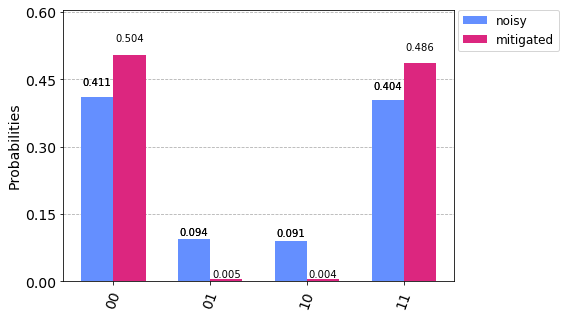

In [11]:
# get the filler object
meas_filter = meas_fitter.filter

# results with mitigation 
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)

plot_histogram([noisy_counts, mitigated_counts], legend=['noisy','mitigated'])

## Activity 1

In [12]:
qc = QuantumCircuit(3,3)
qc.h(0)
qc.cx(0,1)
qc.x(2)
qc.measure(qc.qregs[0], qc.cregs[0])

results = execute(qc, backend=backend, shots=10000, noise_model=noise_model).result()

noisy_counts = results.get_counts()
print(noisy_counts)

{'001': 90, '010': 87, '100': 3719, '110': 838, '011': 434, '111': 3626, '000': 422, '101': 784}


In [13]:
qr = QuantumRegister(3)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

for circuit in meas_calibs:
    print('Circuit',circuit.name)
    print(circuit)
    print()

Circuit mcalcal_000
        ░ ┌─┐      
q66_0: ─░─┤M├──────
        ░ └╥┘┌─┐   
q66_1: ─░──╫─┤M├───
        ░  ║ └╥┘┌─┐
q66_2: ─░──╫──╫─┤M├
        ░  ║  ║ └╥┘
 c1: 3/════╩══╩══╩═
           0  1  2 

Circuit mcalcal_001
       ┌───┐ ░ ┌─┐      
q66_0: ┤ X ├─░─┤M├──────
       └───┘ ░ └╥┘┌─┐   
q66_1: ──────░──╫─┤M├───
             ░  ║ └╥┘┌─┐
q66_2: ──────░──╫──╫─┤M├
             ░  ║  ║ └╥┘
 c1: 3/═════════╩══╩══╩═
                0  1  2 

Circuit mcalcal_010
             ░ ┌─┐      
q66_0: ──────░─┤M├──────
       ┌───┐ ░ └╥┘┌─┐   
q66_1: ┤ X ├─░──╫─┤M├───
       └───┘ ░  ║ └╥┘┌─┐
q66_2: ──────░──╫──╫─┤M├
             ░  ║  ║ └╥┘
 c1: 3/═════════╩══╩══╩═
                0  1  2 

Circuit mcalcal_011
       ┌───┐ ░ ┌─┐      
q66_0: ┤ X ├─░─┤M├──────
       ├───┤ ░ └╥┘┌─┐   
q66_1: ┤ X ├─░──╫─┤M├───
       └───┘ ░  ║ └╥┘┌─┐
q66_2: ──────░──╫──╫─┤M├
             ░  ║  ║ └╥┘
 c1: 3/═════════╩══╩══╩═
                0  1  2 

Circuit mcalcal_100
             ░ ┌─┐      
q66_0: ──────░─┤

In [14]:
noise_model = get_noise(0.1)

backend = Aer.get_backend('qasm_simulator')
job = execute(meas_calibs, backend=backend, shots=1000, noise_model=noise_model)
cal_results = job.result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.749 0.093 0.073 0.005 0.089 0.01  0.006 0.   ]
 [0.062 0.739 0.003 0.068 0.005 0.067 0.001 0.011]
 [0.078 0.004 0.737 0.083 0.014 0.001 0.084 0.007]
 [0.007 0.072 0.075 0.739 0.    0.009 0.009 0.074]
 [0.086 0.005 0.01  0.001 0.731 0.086 0.086 0.012]
 [0.012 0.08  0.002 0.007 0.071 0.732 0.009 0.083]
 [0.006 0.    0.091 0.006 0.081 0.011 0.726 0.091]
 [0.    0.007 0.009 0.091 0.009 0.084 0.079 0.722]]


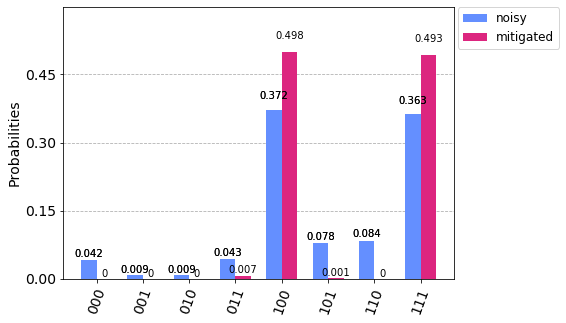

In [15]:
# get the filler object
meas_filter = meas_fitter.filter

# results with mitigation 
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)

plot_histogram([noisy_counts, mitigated_counts], legend=['noisy','mitigated'])